In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
#variables to modify
n_sensors = 22
folder_name = 'bluesky_data'
first_timestamp = "2023-12-18 00:00:00"
last_timestamp = "2023-12-31 16:00:00" #--fill data if there are missing values between these timestamps
parameter = "PM 2.5" #set the parameter you want to harmonize

#read data
data = []
data = [pd.read_csv(f'{folder_name}/B' + str(i+1) + '_15minute_average.csv') for i in range(n_sensors)]

print("checking the lengths of the sensor data:")
u = [len(data[i]["PM 2.5"]) for i in range(n_sensors)]
print(u)

checking the lengths of the sensor data:
[1313, 1313, 1313, 1038, 1313, 1313, 1313, 1313, 1299, 1313, 1070, 1313, 1313, 1313, 1313, 1313, 1313, 1313, 1313, 1284, 1313, 1070]


In [3]:
#convert the timestamps to datetime type
for i in range(n_sensors):
    data[i]['Timestamp'] = pd.to_datetime(data[i]['Timestamp'])

#set the timestamps as index
start = pd.to_datetime(first_timestamp)
end = pd.to_datetime(last_timestamp)
dates = pd.date_range(start=start, end=end, freq='15Min')

#fill the missing values with nan
data = [data[i].set_index('Timestamp').reindex(dates).reset_index() for i in range(n_sensors)]
#print(data[3])

In [4]:
#remove the timestamp with nan values in [0] for every sensor
#data = [data[i][data[0]["PM 2.5"].notna()] for i in range(n_sensors)]

#finding the median values for each timestamp
pm25 = [data[i]["PM 2.5"].values for i in range(n_sensors)]

#cut off sensors with missing days to find the median in a simpler way
pm25 = np.array([pm25[i] for i in range(n_sensors) if len(pm25[i]) == len(pm25[0])])
median = np.nanmedian(pm25, axis=0)

#truncation method
#data = [data[i].truncate(before=408) for i in range(n_sensors)]


/home/sakengali/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


'truncation method'

fitting equations for sensor harmonizations:
sensor 0:y=1.063x
sensor 1:y=0.84x
sensor 2:y=1.136x
sensor 3:y=0.953x
sensor 4:y=0.946x
sensor 5:y=0.954x
sensor 6:y=0.92x
sensor 7:y=0.854x
sensor 8:y=2.156x
sensor 9:y=0.822x
sensor 10:y=1.042x
sensor 11:y=1.091x
sensor 12:y=1.091x
sensor 13:y=1.121x
sensor 14:y=0.94x
sensor 15:y=0.98x
sensor 16:y=1.145x
sensor 17:y=1.131x
sensor 18:y=0.841x
sensor 19:y=0.819x
sensor 20:y=0.863x
sensor 21:y=1.069x


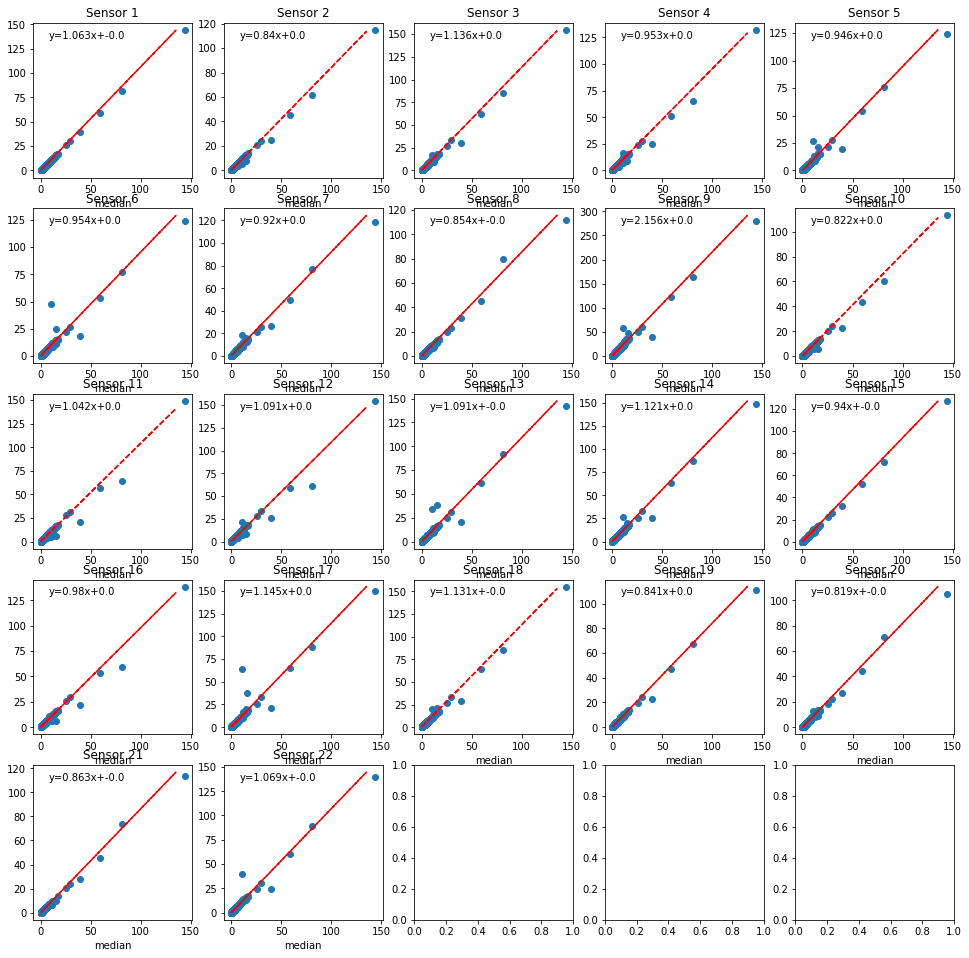

In [40]:
#for plotting
figure, axis = plt.subplots(5, n_sensors//5+1)

#for regression
def func(x, a, b):
    return a*x + b

#to save calibration factors
pm25_calibration = np.zeros(n_sensors)

x = median
print('fitting equations for sensor harmonizations:')
for i in range(n_sensors):
    try:
        #plot the sensors' data against the median (the values are centralized to zero)
        axis[i//5, i%5].plot(data[0]['PM 2.5'], data[i]['PM 2.5'], 'o')
        axis[i//5, i%5].set_title(f"Sensor {i+1}")
        axis[i//5, i%5].set_xlabel("median")

        #regression for slope
        y = data[i]['PM 2.5'].values
        
        #to omit values with nan
        valid = ~ (np.isnan(x) | np.isnan(y))

        #regression (the values are centralized to zero, by setting the intercept to zero)
        popt, pcov = curve_fit(func, x[valid], y[valid], bounds=([-np.inf, -0.000001], [np.inf, 0.000001]))
        pm25_calibration[i] = round(1/popt[0], 3)
        print(f"sensor {i+1}:y={popt[0].round(3)}x")

        #plot the regression line
        axis[i//5, i%5].plot(x, func(x, *popt), 'r--')
        axis[i//5, i%5].text(0.1, 0.9, f"y={popt[0].round(3)}x+{popt[1].round(3)}", transform=axis[i//5, i%5].transAxes)

        
    except ValueError as e:
        print(f"Sensor {i+1} has missing values, check individually; the error is '{e}'")

    #regress the data with zero-tion, and show the equation in the plot

#increase the plot's size
figure.set_size_inches(16.5, 16.5)

plt.savefig('pm25_calibration_fitting.png', dpi=300)
plt.show()

#save the picture in high quality png, and pdf
#write a new csv, from dataframe, where the first column is sensors, and the others are calibration factors for pm2.5, pm1, co2 etc
df_calibration = pd.DataFrame(pm25_calibration)
df_calibration.to_csv('calibration.csv', header=["PM2.5 CF"] )

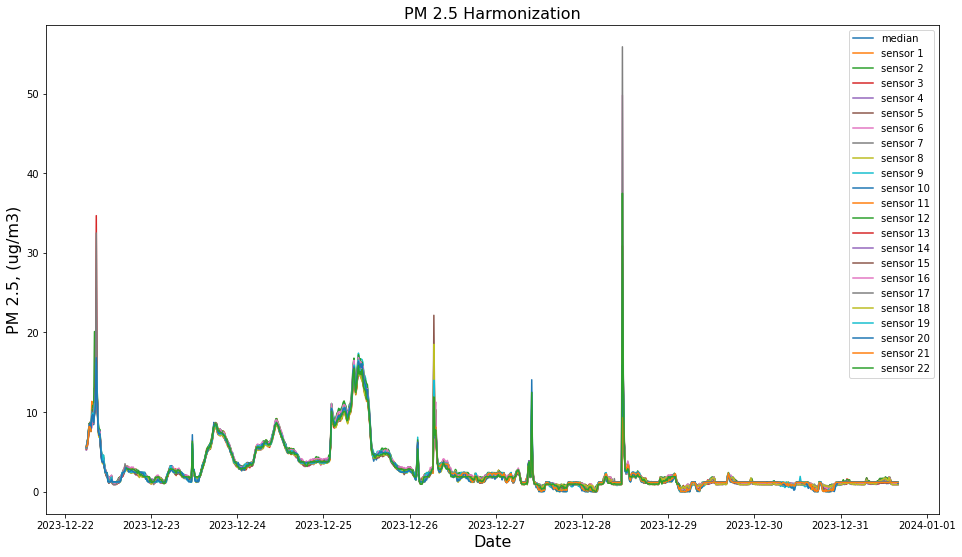

In [30]:
#plots
#plot, truncating before 408
plt.figure(figsize=(16,9))
plt.plot(dates[408:], median[408:], label="median")
for i in range(n_sensors):
    plt.plot(dates[408:], data[i]['PM 2.5'].iloc[408:]*pm25_calibration[i], label=f"sensor {i+1}")

#to plot data before harmonization
#for i in range(n_sensors):
#    plt.plot(dates[408:], data[i]['PM 2.5'].iloc[408:], label=f"sensor {i+1}")

plt.xlabel("Date", fontsize=16)
plt.ylabel("PM 2.5, (ug/m3)", fontsize=16)
plt.legend(loc="upper right")
plt.title("PM 2.5 Harmonization", fontsize=16)
plt.savefig('calibration_pm25.png', dpi=300)
plt.show()

In [42]:
#refine the code, and upload to github

#maybe write a .py file, with this code, where there is function taking the parameter, and returning the calibration factors for that parameter
#then in the main file, save these calibration factors in a csv file
